# ノートブック06: サポートベクターマシン (SVM) とカーネル法

## 学習目標

このノートブックでは、サポートベクターマシン (SVM) とカーネル法について学びます:

1. **SVMの基礎**
   - マージン最大化の原理
   - サポートベクターの役割
   - ハードマージンとソフトマージン

2. **線形SVM**
   - 線形分離可能なデータへの適用
   - Cパラメータの意味と調整

3. **カーネル法**
   - カーネルトリックの原理
   - RBF (Radial Basis Function) カーネル
   - 多項式カーネル
   - シグモイドカーネル

4. **非線形分類**
   - make_moons、make_circlesデータセット
   - カーネル別の決定境界の可視化

5. **ハイパーパラメータチューニング**
   - GridSearchCVによるC、gammaの最適化
   - 過学習と未学習のバランス

6. **実践例**
   - 乳がん診断データセット
   - 他の分類器との比較

---

## セットアップ

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import make_classification, make_moons, make_circles, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

# ランダムシード固定
np.random.seed(42)

print("Setup complete!")

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


Setup complete!


---

## 1. SVMの基礎: マージン最大化

### SVMとは？

サポートベクターマシン（SVM）は、**マージンを最大化**することで分類境界を決定する手法です。
1990年代にVapnikらによって開発され、ディープラーニング登場前は最も強力な分類手法の一つでした。

---

### 🎯 なぜ「マージン最大化」が良いのか？

#### 直感的な説明

```
2クラスを分離する直線は無限に引ける:

    クラスA: ●●●●              クラスB: ■■■■
    
    候補1: ●●●● | ■■■■        ← 境界がAに近すぎる
    候補2: ●●●●    |   ■■■■   ← 境界が中央（マージン最大）
    候補3: ●●●●        |■■■■  ← 境界がBに近すぎる

どれが良い？ → 候補2（両クラスから最も離れている）
```

**理由**: 
- 新しいデータは訓練データと完全に同じではない（ノイズがある）
- 境界に余裕があれば、多少ずれても正しく分類できる
- **マージンが大きい = 汎化性能が高い**

#### 数学的な直感（構造的リスク最小化）

```
従来の手法: 訓練誤差を最小化
  → 訓練データに過剰適合するリスク

SVM: 訓練誤差 + モデルの複雑さ を最小化
  → マージン最大化 = モデルの複雑さを制限
  → 汎化性能が向上
```

---

### 📏 マージンとサポートベクター

```
                サポートベクター
                     ↓
    ●               ●  ← マージン境界（正の超平面）
    ●   ●         /
          ●      /  ← マージン
                /
    ──────────●────────  ← 決定境界（ w·x + b = 0 ）
              \
               \  ← マージン
                \
    ■   ■        ■  ← マージン境界（負の超平面）
        ■    ■       ↑
                サポートベクター
```

**用語の説明**:
- **決定境界**: クラスを分ける超平面（2Dなら直線、3Dなら平面）
- **マージン**: 決定境界と最も近いデータ点との距離
- **サポートベクター**: マージン境界上にあるデータ点（決定境界を「支える」点）

**重要なポイント**:
- サポートベクター**だけ**がモデルを決定する
- 他のデータ点は削除しても結果は同じ
- サポートベクターが少ない = モデルがシンプル = 汎化性能が高い

---

### 🔢 数式で理解するSVM

#### 線形SVMの定式化

決定境界: $w \cdot x + b = 0$

**目的**: マージン $\frac{2}{\|w\|}$ を最大化

これは以下の最適化問題と等価:

$$\min_{w, b} \frac{1}{2} \|w\|^2$$

制約条件: $y_i(w \cdot x_i + b) \geq 1$ （全てのサンプルが正しく分類される）

```
なぜ ||w||² を最小化？

マージン = 2 / ||w||

||w|| が小さい → マージンが大きい
||w||² を最小化 = マージンを最大化
```

---

### 🎓 SVMが他の手法と違う点

| 観点 | ロジスティック回帰 | 決定木 | SVM |
|------|------------------|--------|-----|
| **最適化目標** | 尤度最大化 | 不純度最小化 | マージン最大化 |
| **使うデータ** | 全データ | 全データ | サポートベクターのみ |
| **過学習対策** | 正則化 | 剪定 | マージン（構造的） |
| **非線形対応** | 特徴量設計 | 自動 | カーネル法 |

### 線形SVMのデモ

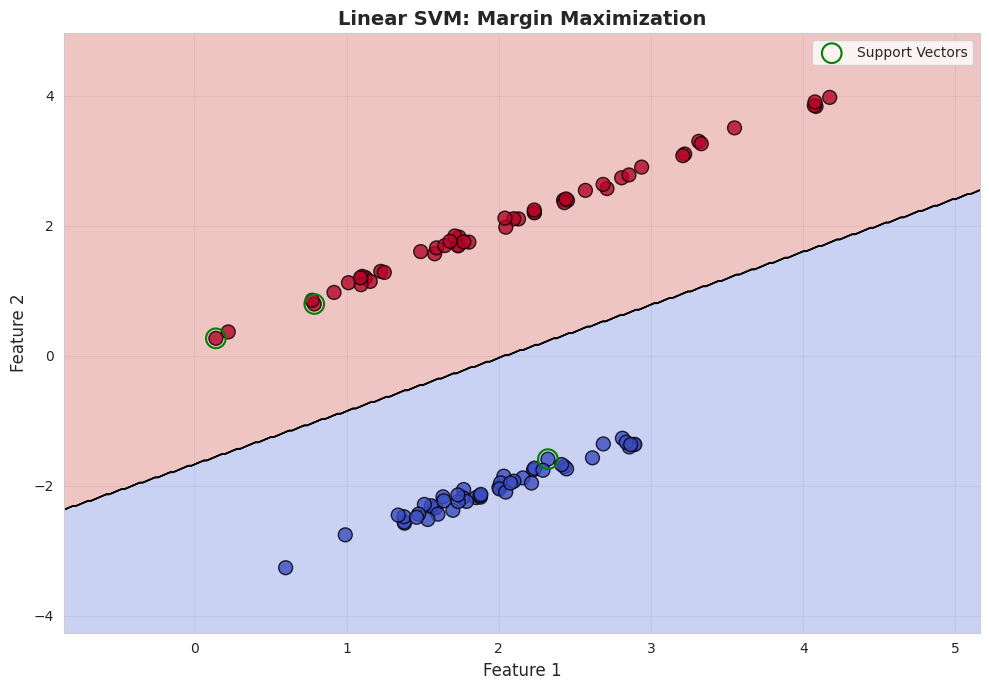

Number of support vectors: 3
Total data points: 100
Percentage of support vectors: 3.0%


In [2]:
# 線形分離可能なデータの生成
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=42
)

# 線形SVMの訓練
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X, y)

# 決定境界とマージンの可視化
def plot_svm_decision_boundary(model, X, y, title='SVM Decision Boundary'):
    plt.figure(figsize=(10, 7))
    
    # メッシュグリッドの作成
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # 予測
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 決定境界のプロット
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)
    
    # データポイントのプロット
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', 
                edgecolors='k', s=100, alpha=0.8)
    
    # サポートベクターの強調表示
    if hasattr(model, 'support_vectors_'):
        plt.scatter(model.support_vectors_[:, 0], 
                    model.support_vectors_[:, 1],
                    s=200, linewidth=1.5, facecolors='none', 
                    edgecolors='green', label='Support Vectors')
    
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_svm_decision_boundary(svm_linear, X, y, 'Linear SVM: Margin Maximization')

print(f"Number of support vectors: {len(svm_linear.support_vectors_)}")
print(f"Total data points: {len(X)}")
print(f"Percentage of support vectors: {len(svm_linear.support_vectors_) / len(X) * 100:.1f}%")

### 観察ポイント

1. **サポートベクター (緑の円)**: 決定境界に最も近いポイント。これらのポイントだけがモデルの決定に影響
2. **マージン**: サポートベクターと決定境界の距離が最大化されている
3. **汎化性能**: マージンが大きいほど、未知のデータに対する性能が向上

---

## 2. Cパラメータ: ソフトマージンSVM

### 🤔 現実のデータは完全に分離できない

前のセクションでは「完全に線形分離可能」なデータを扱いました。
しかし、現実のデータには**ノイズ**や**外れ値**があり、完全な分離は不可能です。

```
理想的なデータ:               現実のデータ:
  ●●●●    |    ■■■■           ●●●●  ■ |    ■■■■
                                    ↑
                               外れ値（ノイズ）

完全分離を求めると:
  - 外れ値に引きずられて境界が歪む
  - マージンが極端に小さくなる
  - 過学習につながる
```

---

### 🎛️ ソフトマージンSVMの登場

**ソフトマージンSVM**は、**ある程度の誤分類を許容**することでこの問題を解決します。

$$\min_{w, b, \xi} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{N} \xi_i$$

- $\xi_i$: **スラック変数**（各サンプルの誤分類の度合い）
- $C$: **正則化パラメータ**（誤分類へのペナルティ）

```
スラック変数の意味:

  ξ = 0: サンプルはマージンの外側（正しく分類）
  0 < ξ < 1: サンプルはマージン内だが正しい側
  ξ = 1: サンプルは決定境界上
  ξ > 1: サンプルは誤分類されている
```

---

### 📊 Cパラメータの役割

**C**はマージンの大きさと誤分類のトレードオフを制御します。

```
C が大きい（例: C=100）:
  - 誤分類へのペナルティが大きい
  - 「できるだけ誤分類を避けろ！」
  - → マージンが小さくなる
  - → 過学習のリスク
  - → サポートベクターが少なくなる

C が小さい（例: C=0.01）:
  - 誤分類へのペナルティが小さい
  - 「多少の誤分類はOK、マージンを優先」
  - → マージンが大きくなる
  - → 未学習のリスク
  - → サポートベクターが多くなる
```

#### 直感的な例

```
教室での席替え問題:

C が大きい先生:
  「絶対に男子と女子を完全に分けろ！」
  → 複雑な境界線を引く
  → 一人の外れ値のために全体が歪む

C が小さい先生:
  「だいたい分かれてればOK」
  → シンプルな境界線
  → 一部混在してもOK
```

---

### 🎯 Cの選び方

| C の値 | マージン | 誤分類 | 適した状況 |
|--------|----------|--------|------------|
| **小さい (0.01-0.1)** | 大きい | 多い | ノイズが多いデータ |
| **中程度 (1)** | 中程度 | 中程度 | 一般的なデータ |
| **大きい (10-100)** | 小さい | 少ない | クリーンなデータ |

**実践的なアドバイス**:
- まず `C=1` で試す
- `GridSearchCV` で `C=[0.01, 0.1, 1, 10, 100]` を探索
- 訓練精度とテスト精度の差が大きい → Cを下げる
- 両方の精度が低い → Cを上げる

### Cの影響を可視化

In [ ]:
# Cの効果がはっきり見えるデータを作成
# 外れ値と偏りのあるデータ
np.random.seed(42)

# クラス0: 左下に密集（多め）
X0_main = np.random.randn(60, 2) * 0.5 + np.array([-2, -1])

# クラス1: 右上に密集（少なめ）
X1_main = np.random.randn(40, 2) * 0.5 + np.array([2, 1])

# 外れ値: クラス0だが右側にある（クラス1の領域に侵入）
X0_outliers = np.array([[1.5, 0.5], [1.0, -0.5], [0.5, 1.0], [1.8, -0.2]])

# 外れ値: クラス1だが左側にある（クラス0の領域に侵入）
X1_outliers = np.array([[-1.0, 0.5], [-0.5, -1.0], [-1.5, 0.0]])

# 中間地帯のノイズ
X0_noise = np.array([[0, 0], [-0.3, 0.5], [0.2, -0.3]])
X1_noise = np.array([[0.3, 0.2], [-0.2, 0.8], [0.5, 0]])

# データを結合
X_noisy = np.vstack([X0_main, X0_outliers, X0_noise, X1_main, X1_outliers, X1_noise])
y_noisy = np.array([0]*60 + [0]*4 + [0]*3 + [1]*40 + [1]*3 + [1]*3)

print(f"データ生成完了: {len(X_noisy)} samples")
print(f"クラス分布: Class 0 = {sum(y_noisy==0)}, Class 1 = {sum(y_noisy==1)}")
print(f"外れ値: Class 0に4個, Class 1に3個")

# 異なるCの値でSVMを訓練
C_values = [0.001, 0.1, 10, 1000]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, C in enumerate(C_values):
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_noisy, y_noisy)
    
    # メッシュグリッドの作成
    h = 0.02
    x_min, x_max = X_noisy[:, 0].min() - 0.5, X_noisy[:, 0].max() + 0.5
    y_min, y_max = X_noisy[:, 1].min() - 0.5, X_noisy[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 決定関数の値（マージンからの距離）
    Z_decision = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_decision = Z_decision.reshape(xx.shape)
    
    # プロット
    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    # マージン境界を表示（decision_function = -1, 0, 1）
    axes[idx].contour(xx, yy, Z_decision, levels=[-1, 0, 1], 
                      colors=['blue', 'black', 'red'], 
                      linestyles=['--', '-', '--'], linewidths=[1.5, 2.5, 1.5])
    
    # データポイント（メインクラスタ）
    axes[idx].scatter(X_noisy[:, 0], X_noisy[:, 1], c=y_noisy, 
                      cmap='coolwarm', edgecolors='k', s=60, alpha=0.8)
    
    # 外れ値を強調（四角でマーク）
    outlier_indices = list(range(60, 67)) + list(range(107, 113))  # 外れ値のインデックス
    axes[idx].scatter(X_noisy[outlier_indices, 0], X_noisy[outlier_indices, 1],
                      c=y_noisy[outlier_indices], cmap='coolwarm',
                      marker='s', s=120, edgecolors='yellow', linewidths=2,
                      label='外れ値')
    
    # サポートベクターを強調
    axes[idx].scatter(svm.support_vectors_[:, 0], 
                      svm.support_vectors_[:, 1],
                      s=180, linewidth=2, facecolors='none', 
                      edgecolors='lime', label='Support Vectors')
    
    # 訓練精度と誤分類数を計算
    train_acc = svm.score(X_noisy, y_noisy)
    y_pred = svm.predict(X_noisy)
    n_misclassified = (y_pred != y_noisy).sum()
    
    axes[idx].set_xlabel('Feature 1', fontsize=11)
    axes[idx].set_ylabel('Feature 2', fontsize=11)
    axes[idx].set_title(f'C = {C}\n'
                        f'サポートベクター: {len(svm.support_vectors_)}個 | '
                        f'誤分類: {n_misclassified}個\n'
                        f'訓練精度: {train_acc:.1%}',
                        fontsize=11, fontweight='bold')
    axes[idx].legend(loc='upper left', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Cパラメータの影響: 外れ値への対応の違い', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*65)
print("💡 観察ポイント（破線=マージン境界、実線=決定境界）")
print("="*65)
print("""
【C = 0.001（非常に小さい）】
  → 外れ値を無視してマージンを最大化
  → 誤分類を多く許容するが、境界は安定
  → サポートベクターが多い

【C = 0.1（小さい）】
  → 外れ値の影響を受け始める
  → マージンと誤分類のバランス

【C = 10（大きい）】
  → 外れ値をできるだけ正しく分類しようとする
  → マージンが狭くなる

【C = 1000（非常に大きい）】
  → すべての点を正しく分類しようとする
  → 外れ値に引きずられて境界が歪む
  → 過学習のリスク

※ 黄色の四角 = 外れ値（反対クラス側にある点）
""")

---

## 3. カーネル法: 非線形分類への拡張

### 🤔 線形SVMの限界

現実のデータは直線では分離できないことが多い:

```
例1: ドーナツ型データ（Circles）

        ■ ■ ■ ■
      ■         ■
    ■   ● ● ●   ■
    ■  ●     ●  ■      直線では分離不可能！
    ■   ● ● ●   ■
      ■         ■
        ■ ■ ■ ■

例2: 三日月型データ（Moons）

      ● ● ● ●
    ●           ●
              ■ ■ ■ ■    直線では分離不可能！
            ■           ■
```

---

### 💡 解決のアイデア: 高次元に持ち上げる

**核心**: 低次元で分離できなくても、**高次元なら分離できる**！

#### 具体例: ドーナツ型データを分離する

```
【元のデータ（2次元）】

  ●: 中心付近（x² + y² が小さい）
  ■: 外周付近（x² + y² が大きい）

      y
      ↑    ■ ■
      │  ■ ● ● ■
      │  ■ ● ● ■
      └──■─■─■──→ x
      
  → どんな直線を引いても分離不可能


【高次元に変換（3次元）】

  変換関数 φ: (x, y) → (x, y, x² + y²)
                            ↑
                         新しい軸 z
  
      z（= x² + y²）
      ↑
      │    ■ ■ ■ ■     ← z が大きい（外周）
      │  ────────────  ← この平面で分離！
      │    ● ● ● ●     ← z が小さい（中心）
      └────────────→ x, y
      
  → 3次元なら平面（z = c）で分離可能！
```

---

### 🎩 カーネルトリック: 高次元計算の裏技

#### 問題: 高次元変換は計算コストが爆発する

```
多項式変換の次元数:

  元の次元  ×  多項式の次数  →  変換後の次元
  ─────────────────────────────────────────
     10     ×      2        →      66
    100     ×      2        →    5,151
   1000     ×      2        → 501,501
   
  → メモリも計算時間も爆発！
```

#### SVMの計算で必要なのは「内積」だけ

実はSVMの最適化計算では、データ点そのものではなく、
**データ点同士の内積**しか使いません（数学的な詳細は省略）。

```
SVMが必要とするもの:

  高次元での内積: <φ(x), φ(x')> = φ(x) · φ(x')
  
  ※ φ(x): x を高次元に変換したベクトル
  ※ x, x': 2つのデータ点
```

#### カーネルトリックの発見

ここで数学者たちが気づいた驚くべき事実:

```
【大発見】

ある特別な関数 K(x, x') を使うと:

  K(x, x') = <φ(x), φ(x')>
  
が成り立つ！

つまり:
  - 左辺: 元の空間でKを計算（簡単）
  - 右辺: 高次元で内積を計算（大変）
  
  → 左辺だけ計算すれば、右辺の結果が得られる！
```

**「なぜそんな都合の良い関数Kが存在するの？」**

→ これは数学的に証明されています（Mercerの定理）。
→ 証明は大学院レベルの数学が必要で、ここでは省略します。
→ 重要なのは「そういう便利な関数Kが存在する」という事実です。

---

### 📐 具体例で「なぜ成り立つか」を確認

証明は難しいですが、**具体的な数値で成り立つことを確認**できます。

```
【多項式カーネル（次数2）で確認】

データ点: x = (1, 2),  x' = (3, 4)

─────────────────────────────────────────────────
【方法1】高次元に変換してから内積を計算

  変換関数: φ(x) = (x₁², √2·x₁x₂, x₂²)
  
  φ(x)  = (1², √2·1·2, 2²) = (1, 2√2, 4)
  φ(x') = (3², √2·3·4, 4²) = (9, 12√2, 16)
  
  内積:
  <φ(x), φ(x')> = 1×9 + 2√2×12√2 + 4×16
                = 9 + 48 + 64
                = 121

─────────────────────────────────────────────────
【方法2】カーネル関数で直接計算

  カーネル関数: K(x, x') = (x · x')²
  
  まず元の空間で内積:
  x · x' = 1×3 + 2×4 = 3 + 8 = 11
  
  カーネル値:
  K(x, x') = 11² = 121

─────────────────────────────────────────────────
【結果】両方とも 121 で一致！

  方法1: 3次元のベクトルを2つ作って内積
  方法2: 2次元のまま内積して2乗
  
  → 方法2の方が圧倒的に計算が楽！
```

#### なぜ一致するのか？（数学的なヒント）

```
(x · x')² を展開すると:

  (x₁x'₁ + x₂x'₂)²
  = x₁²x'₁² + 2x₁x₂x'₁x'₂ + x₂²x'₂²
  = (x₁²)(x'₁²) + (√2·x₁x₂)(√2·x'₁x'₂) + (x₂²)(x'₂²)
  = <φ(x), φ(x')>  ← 高次元での内積と同じ形！

→ 代数的に展開すると、高次元での内積と同じになる
→ これが「なぜKで内積が計算できるか」の答え
→ 各カーネルは、対応するφが存在するよう設計されている
```

---

### 🔑 カーネルトリックのまとめ

```
【普通のアプローチ】
  1. x を高次元に変換 → φ(x)     [メモリ・計算コスト大]
  2. x' を高次元に変換 → φ(x')   [メモリ・計算コスト大]
  3. 内積を計算 → <φ(x), φ(x')>

【カーネルトリック】
  1. 元の空間で K(x, x') を計算   [コスト小]
  
  K(x, x') = <φ(x), φ(x')> が数学的に保証されている！
  
  → 高次元に変換せずに、高次元での内積が得られる！
  → 「高次元に行ったフリをして、行かない」のがトリック
```

**ポイント**:
- K(x, x') は「カーネル関数」と呼ばれる
- 各カーネル関数には、対応する高次元変換φが（暗黙的に）存在する
- RBFカーネルは**無限次元**への変換に相当（！）
- 私たちはφを知らなくても、Kさえ知っていればSVMが使える

---

### 📚 主要なカーネル関数

#### 1. 線形カーネル
$$K(x, x') = x \cdot x'$$

```
対応する変換: φ(x) = x（変換なし）
特徴: 元の空間そのまま、最もシンプル
用途: テキスト分類、高次元スパースデータ
```

#### 2. RBFカーネル（ガウシアンカーネル）⭐最重要
$$K(x, x') = \exp\left(-\gamma \|x - x'\|^2\right)$$

```
対応する変換: φ(x) = 無限次元ベクトル（！）
特徴: 最も汎用的、ほとんどの非線形パターンに対応
仕組み: 距離が近い → K≈1、遠い → K≈0（類似度を測定）
用途: とりあえずこれを使えばOK
```

#### 3. 多項式カーネル
$$K(x, x') = (x \cdot x' + c)^d$$

```
対応する変換: φ(x) = d次までの全ての単項式
特徴: 次数dを指定、多項式的な境界
用途: 画像認識など
```

---

### 🎯 カーネルの選び方

```
Step 1: まず線形カーネルを試す
        ↓ うまくいかない
Step 2: RBFカーネルを試す（デフォルト推奨）
        ↓ うまくいかない
Step 3: 多項式カーネル / パラメータ調整
```

| データの特徴 | 推奨カーネル |
|-------------|-------------|
| 線形分離可能 | linear |
| 特徴量数 >> サンプル数 | linear |
| 非線形パターン | rbf（まずこれ） |
| よくわからない | rbf |

### 非線形データでのカーネル比較

In [ ]:
# カーネルトリックの視覚的理解: 高次元への変換
from mpl_toolkits.mplot3d import Axes3D

# ドーナツ型データ（Circles）を生成
X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.4, random_state=42)

fig = plt.figure(figsize=(16, 5))

# 1. 元の2次元データ（分離不可能）
ax1 = fig.add_subplot(131)
ax1.scatter(X_circles[y_circles==0, 0], X_circles[y_circles==0, 1], 
            c='blue', label='Class 0 (内側)', s=50, alpha=0.7, edgecolors='k')
ax1.scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], 
            c='red', label='Class 1 (外側)', s=50, alpha=0.7, edgecolors='k')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title('① 元の2次元データ\n（直線では分離不可能）', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# 2. 高次元に変換（z = x² + y²）
z = X_circles[:, 0]**2 + X_circles[:, 1]**2

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_circles[y_circles==0, 0], X_circles[y_circles==0, 1], z[y_circles==0],
            c='blue', label='Class 0', s=50, alpha=0.7)
ax2.scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], z[y_circles==1],
            c='red', label='Class 1', s=50, alpha=0.7)

# 分離平面を描画
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 10), np.linspace(-1.5, 1.5, 10))
zz = np.ones_like(xx) * 0.5  # z = 0.5 の平面
ax2.plot_surface(xx, yy, zz, alpha=0.3, color='green')

ax2.set_xlabel('x', fontsize=10)
ax2.set_ylabel('y', fontsize=10)
ax2.set_zlabel('z = x² + y²', fontsize=10)
ax2.set_title('② 3次元に変換\n（平面で分離可能！）', fontsize=12, fontweight='bold')
ax2.view_init(elev=20, azim=45)

# 3. 元の空間での決定境界（RBFカーネルSVM）
ax3 = fig.add_subplot(133)

svm_rbf = SVC(kernel='rbf', C=1.0, gamma=2)
svm_rbf.fit(X_circles, y_circles)

h = 0.02
x_min, x_max = X_circles[:, 0].min() - 0.5, X_circles[:, 0].max() + 0.5
y_min, y_max = X_circles[:, 1].min() - 0.5, X_circles[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svm_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax3.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
ax3.contour(xx, yy, Z, colors='k', linewidths=2)
ax3.scatter(X_circles[y_circles==0, 0], X_circles[y_circles==0, 1], 
            c='blue', label='Class 0', s=50, alpha=0.7, edgecolors='k')
ax3.scatter(X_circles[y_circles==1, 0], X_circles[y_circles==1, 1], 
            c='red', label='Class 1', s=50, alpha=0.7, edgecolors='k')
ax3.set_xlabel('x', fontsize=12)
ax3.set_ylabel('y', fontsize=12)
ax3.set_title('③ RBFカーネルSVMの結果\n（円形の境界を学習）', fontsize=12, fontweight='bold')
ax3.legend()
ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*70)
print("💡 カーネルトリックの核心")
print("="*70)
print("""
【左】元の2次元データ
  - 内側（青）と外側（赤）のドーナツ型
  - どんな直線を引いても分離できない

【中央】3次元に変換: (x, y) → (x, y, x² + y²)
  - z = x² + y² という新しい軸を追加
  - 内側: z が小さい（下）
  - 外側: z が大きい（上）
  - 緑の平面（z = 0.5）で分離可能！

【右】RBFカーネルSVMの結果
  - カーネルトリックにより、実際に3次元に変換せずに
  - 高次元での分離と同等の結果を得られる
  - 元の空間では円形の境界として現れる
""")

# 2つの非線形データセットでカーネル比較
X_moons, y_moons = make_moons(n_samples=200, noise=0.2, random_state=42)

datasets = [
    ('Moons Dataset（三日月型）', X_moons, y_moons),
    ('Circles Dataset（ドーナツ型）', X_circles, y_circles)
]

kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for dataset_name, X_data, y_data in datasets:
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    
    for idx, kernel in enumerate(kernels):
        # SVMモデルの訓練
        if kernel == 'poly':
            svm = SVC(kernel=kernel, degree=3, C=1.0, gamma='auto')
        else:
            svm = SVC(kernel=kernel, C=1.0, gamma='auto')
        
        svm.fit(X_data, y_data)
        
        # メッシュグリッド
        h = 0.02
        x_min, x_max = X_data[:, 0].min() - 0.5, X_data[:, 0].max() + 0.5
        y_min, y_max = X_data[:, 1].min() - 0.5, X_data[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        axes[idx].contour(xx, yy, Z, colors='k', linewidths=1.5)
        axes[idx].scatter(X_data[:, 0], X_data[:, 1], c=y_data, 
                          cmap='coolwarm', edgecolors='k', s=40, alpha=0.8)
        
        accuracy = svm.score(X_data, y_data)
        axes[idx].set_xlabel('Feature 1', fontsize=10)
        axes[idx].set_ylabel('Feature 2', fontsize=10)
        axes[idx].set_title(f'{kernel.upper()}\n精度: {accuracy:.1%}',
                            fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
    
    fig.suptitle(f'{dataset_name}: カーネル比較', 
                 fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("💡 カーネル別の特徴")
print("="*70)
print("""
【LINEAR（線形）】
  - 直線でしか分離できない
  - 非線形データには不向き
  - 精度が低い

【RBF（ガウシアン）】⭐推奨
  - 曲線で分離できる
  - ほとんどの非線形パターンに対応
  - 最も汎用的

【POLY（多項式）】
  - 多項式的な曲線で分離
  - 次数(degree)の調整が必要
  - 特定のパターンに有効

【SIGMOID】
  - ニューラルネットワーク風
  - 実用ではあまり使われない
""")

### 観察ポイント

1. **Moons Dataset**: RBFと多項式カーネルが優れた性能
2. **Circles Dataset**: RBFカーネルが明らかに最適
3. **線形カーネル**: 非線形パターンには不十分

---

## 4. RBFカーネルのgammaパラメータ

### 🔬 gammaパラメータとは？

RBFカーネル: $K(x, x') = \exp(-\gamma \|x - x'\|^2)$

**gamma (γ)** は「各サンプルの影響範囲」を制御します。

---

### 📊 gammaの直感的理解

```
RBFカーネルを「ガウス分布（正規分布）の釣り鐘型」として考える:

gamma が大きい場合:
  
      ▲  ← 鋭いピーク（影響範囲が狭い）
     /|\
    / | \
   /  |  \
  ────●────
       ↑
    このサンプル

  - 近くのサンプルだけが影響を受ける
  - 境界が複雑になる（個々のサンプルに過度に適合）


gamma が小さい場合:
  
    ╱╲  ← なだらかな山（影響範囲が広い）
   ╱  ╲
  ╱    ╲
 ╱      ╲
────●────
     ↑
  このサンプル

  - 遠くのサンプルも影響を受ける
  - 境界が滑らかになる
```

---

### 🎯 gammaと決定境界の関係

```
gamma が小さい（例: 0.01）:
  
    ●●●      ■■■
      ────────────  ← 滑らかな直線に近い境界
    ●●       ■■
    
  - 各サンプルの影響が広範囲
  - 遠くの点も考慮
  - 未学習（underfitting）のリスク


gamma が中程度（例: 1）:
  
    ●●●     ╱■■■
      ╲────╱
    ●● ╲──╱ ■■
    
  - バランスの取れた境界
  - 適切な複雑さ


gamma が大きい（例: 100）:
  
    ●●● ╱╲╱╲ ■■■
     ╲╱  ╲╱
    ●●╱╲  ╱╲■■
    
  - 各サンプルの影響が局所的
  - 境界がギザギザ
  - 過学習（overfitting）のリスク
```

---

### 📐 gammaの数学的意味

$$K(x, x') = \exp(-\gamma \|x - x'\|^2)$$

- $\|x - x'\|^2$: 2点間の距離の二乗
- $\gamma$: 距離への「感度」

```
計算例:

2点間の距離 = 1 の場合:
  gamma = 0.1: K = exp(-0.1 × 1) = exp(-0.1) ≈ 0.90  (高い類似度)
  gamma = 1:   K = exp(-1 × 1)   = exp(-1)   ≈ 0.37
  gamma = 10:  K = exp(-10 × 1)  = exp(-10)  ≈ 0.00  (ほぼ0)

2点間の距離 = 0.1 の場合:
  gamma = 0.1: K = exp(-0.1 × 0.01) ≈ 0.999
  gamma = 1:   K = exp(-1 × 0.01)   ≈ 0.990
  gamma = 10:  K = exp(-10 × 0.01)  ≈ 0.905

→ gammaが大きいと、少し離れただけで類似度が急激に下がる
→ 近くのサンプルのみを考慮 = 複雑な境界
```

---

### 🔧 gammaのデフォルト値

scikit-learnでは:
- `gamma='scale'`（デフォルト）: $\gamma = \frac{1}{n_{features} \times X.var()}$
- `gamma='auto'`: $\gamma = \frac{1}{n_{features}}$

```python
# 明示的に指定する場合
svm = SVC(kernel='rbf', gamma=0.1)

# デフォルト（推奨）
svm = SVC(kernel='rbf', gamma='scale')
```

---

### ⚖️ C と gamma の相互作用

両方のパラメータは**決定境界の複雑さ**に影響:

| C | gamma | 結果 |
|---|-------|------|
| 小 | 小 | 非常に滑らかな境界（未学習リスク） |
| 小 | 大 | 局所的だがペナルティ弱い |
| 大 | 小 | 滑らかだが誤分類を許さない |
| 大 | 大 | 非常に複雑な境界（過学習リスク） |

```
推奨される探索範囲:

C:     [0.1, 1, 10, 100, 1000]
gamma: [0.001, 0.01, 0.1, 1, 10]

GridSearchCVで組み合わせを探索!
```

### gammaの影響を可視化

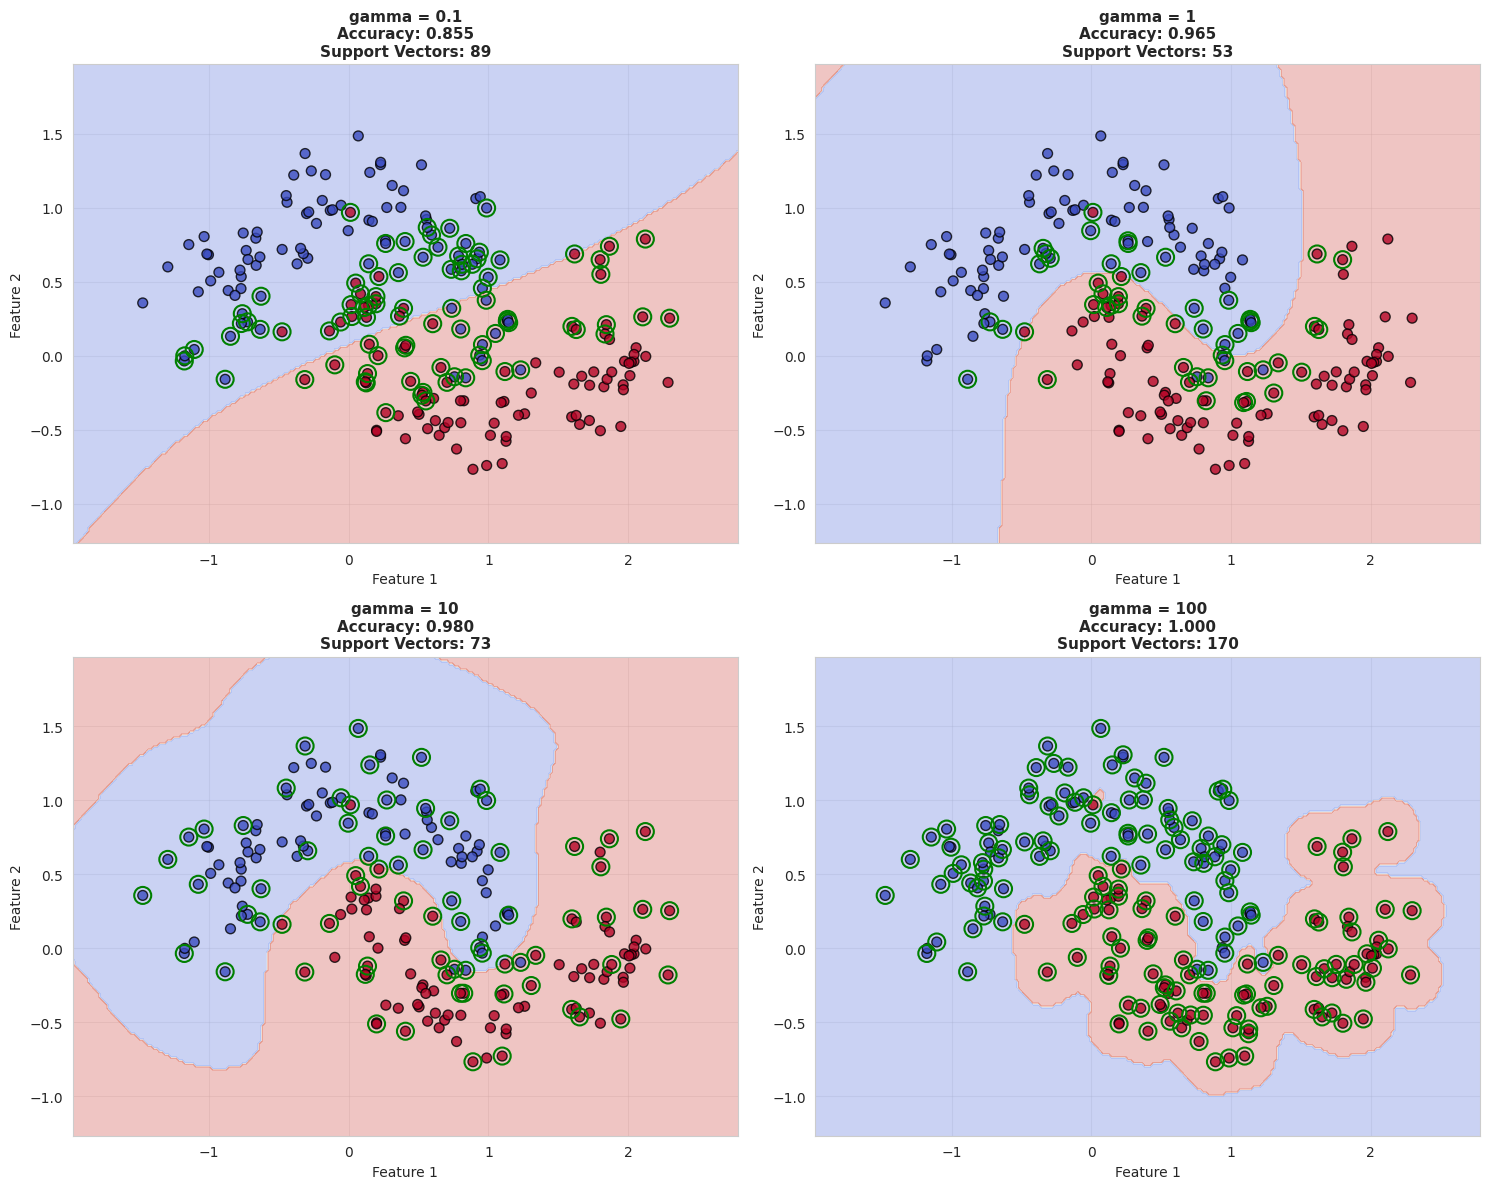


gamma parameter effects:
- Small gamma (0.1): Smooth decision boundary, may underfit
- Medium gamma (1): Balanced complexity
- Large gamma (10, 100): Complex boundary, may overfit


In [5]:
# Moonsデータセットを使用
X_moons, y_moons = make_moons(n_samples=200, noise=0.2, random_state=42)

# 異なるgammaの値でSVMを訓練
gamma_values = [0.1, 1, 10, 100]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, gamma in enumerate(gamma_values):
    svm = SVC(kernel='rbf', C=1.0, gamma=gamma)
    svm.fit(X_moons, y_moons)
    
    # メッシュグリッド
    h = 0.02
    x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
    y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    axes[idx].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, 
                      cmap='coolwarm', edgecolors='k', s=50, alpha=0.8)
    axes[idx].scatter(svm.support_vectors_[:, 0], 
                      svm.support_vectors_[:, 1],
                      s=150, linewidth=1.5, facecolors='none', 
                      edgecolors='green')
    
    accuracy = svm.score(X_moons, y_moons)
    axes[idx].set_xlabel('Feature 1', fontsize=10)
    axes[idx].set_ylabel('Feature 2', fontsize=10)
    axes[idx].set_title(f'gamma = {gamma}\nAccuracy: {accuracy:.3f}\nSupport Vectors: {len(svm.support_vectors_)}',
                        fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\ngamma parameter effects:")
print("- Small gamma (0.1): Smooth decision boundary, may underfit")
print("- Medium gamma (1): Balanced complexity")
print("- Large gamma (10, 100): Complex boundary, may overfit")

---

## 5. ハイパーパラメータチューニング: GridSearchCV

最適なC、gamma、kernelの組み合わせを見つけるために、GridSearchCVを使用します。

Starting Grid Search...
Fitting 5 folds for each of 60 candidates, totalling 300 fits



GRID SEARCH RESULTS

Best Parameters: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
Best CV Score: 0.9643
Test Set Accuracy: 0.9500

Top 5 Parameter Combinations:
                                      params  mean_test_score  std_test_score  \
27    {'C': 1, 'gamma': 10, 'kernel': 'rbf'}         0.964286        0.022588   
39    {'C': 10, 'gamma': 1, 'kernel': 'rbf'}         0.964286        0.022588   
57  {'C': 100, 'gamma': 10, 'kernel': 'rbf'}         0.964286        0.039123   
12  {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}         0.957143        0.026726   
24     {'C': 1, 'gamma': 1, 'kernel': 'rbf'}         0.957143        0.026726   

    rank_test_score  
27                1  
39                1  
57                1  
12                4  
24                4  


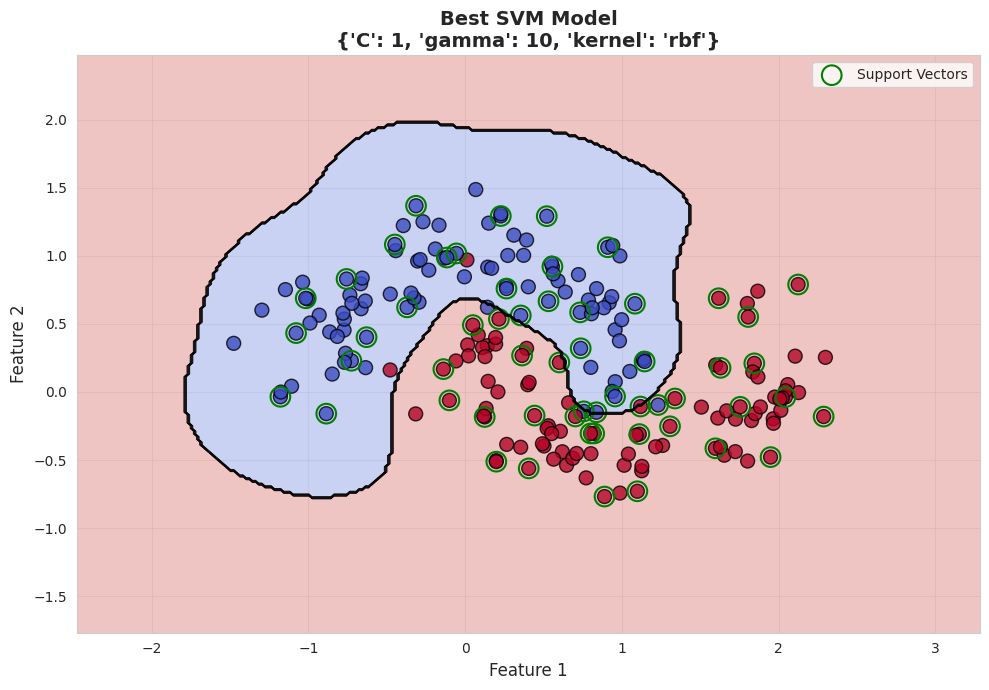

In [6]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=42
)

# パラメータグリッドの定義
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# GridSearchCVの実行
grid_search = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Test Set Accuracy: {grid_search.score(X_test, y_test):.4f}")

# Top 5の結果を表示
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print("\nTop 5 Parameter Combinations:")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head())

# 最適モデルの可視化
best_model = grid_search.best_estimator_
plot_svm_decision_boundary(best_model, X_moons, y_moons, 
                           f'Best SVM Model\n{grid_search.best_params_}')

### C vs gamma のヒートマップ

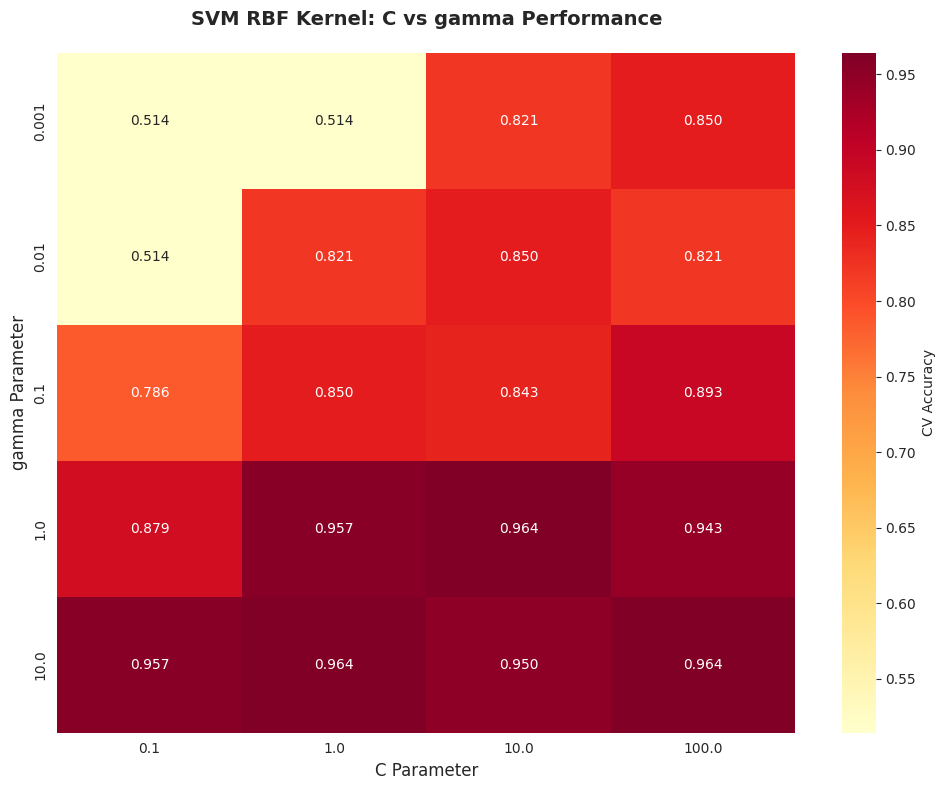


Heatmap Interpretation:
- Dark red regions: Best performance
- Light yellow regions: Poor performance
- Diagonal patterns often indicate overfitting/underfitting balance


In [7]:
# RBFカーネルに限定してヒートマップを作成
rbf_results = results_df[results_df['param_kernel'] == 'rbf'].copy()

# ピボットテーブルの作成
pivot_table = rbf_results.pivot_table(
    values='mean_test_score',
    index='param_gamma',
    columns='param_C'
)

# ヒートマップの可視化
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'CV Accuracy'})
plt.title('SVM RBF Kernel: C vs gamma Performance', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('C Parameter', fontsize=12)
plt.ylabel('gamma Parameter', fontsize=12)
plt.tight_layout()
plt.show()

print("\nHeatmap Interpretation:")
print("- Dark red regions: Best performance")
print("- Light yellow regions: Poor performance")
print("- Diagonal patterns often indicate overfitting/underfitting balance")

---

## 6. 実践例: 乳がん診断データセット

実際のデータセットを使って、SVMの性能を評価します。

In [8]:
# 乳がんデータセットの読み込み
cancer_data = load_breast_cancer()
X_cancer = cancer_data.data
y_cancer = cancer_data.target
feature_names = cancer_data.feature_names

print("Dataset Information:")
print(f"- Samples: {X_cancer.shape[0]}")
print(f"- Features: {X_cancer.shape[1]}")
print(f"- Classes: {len(np.unique(y_cancer))} (Malignant: {sum(y_cancer==0)}, Benign: {sum(y_cancer==1)})")
print(f"\nFeature names (first 10): {list(feature_names[:10])}")

Dataset Information:
- Samples: 569
- Features: 30
- Classes: 2 (Malignant: 212, Benign: 357)

Feature names (first 10): [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension')]


### データの前処理

### ⚠️ SVMでは標準化が必須！

SVMは**特徴量のスケールに非常に敏感**です。標準化せずに使うと、結果が大きく歪みます。

---

### 🤔 なぜ標準化が必要？

```
例: 住宅価格予測

  特徴量1: 面積 (50-200 m²)
  特徴量2: 価格 (1000-5000 万円)

標準化なし:
  
  距離計算: ||x - x'||²
  
  = (面積の差)² + (価格の差)²
  = (100)² + (2000)²
  = 10,000 + 4,000,000
  = 4,010,000
        ↑
    価格が圧倒的に支配！
    面積の情報はほぼ無視される

標準化あり（平均0、標準偏差1）:
  
  = (1.5)² + (1.2)²
  = 2.25 + 1.44
  = 3.69
  
  → 両方の特徴量が公平に寄与
```

---

### 📊 標準化の方法

**StandardScaler**: 平均0、標準偏差1に変換

$$x_{scaled} = \frac{x - \mu}{\sigma}$$

```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 訓練データでfit_transform（平均と標準偏差を学習）
X_train_scaled = scaler.fit_transform(X_train)

# テストデータはtransformのみ（訓練データの統計量を使用）
X_test_scaled = scaler.transform(X_test)
```

**重要**: テストデータには `transform` のみ使用！
- `fit_transform` を使うとデータリークになる
- 訓練データの統計量でテストデータを変換

---

### 🔄 他の正規化手法

| 手法 | 変換 | 用途 |
|------|------|------|
| **StandardScaler** | 平均0、標準偏差1 | SVMで最も一般的 |
| **MinMaxScaler** | 0-1の範囲 | 外れ値が少ない場合 |
| **RobustScaler** | 中央値と四分位範囲 | 外れ値が多い場合 |
| **Normalizer** | 各サンプルのノルム=1 | テキスト分類など |

**SVMでは StandardScaler を推奨**

In [9]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

# 標準化 (SVMでは重要!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing complete.")
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Data preprocessing complete.
Training set: (455, 30)
Test set: (114, 30)


### SVMモデルの訓練と評価

In [10]:
# 複数のカーネルでSVMを訓練
kernels = ['linear', 'rbf', 'poly']
svm_models = {}

print("Training SVM models with different kernels...\n")

for kernel in kernels:
    print(f"Training {kernel.upper()} kernel...")
    
    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=3, C=1.0, random_state=42)
    else:
        svm = SVC(kernel=kernel, C=1.0, random_state=42)
    
    svm.fit(X_train_scaled, y_train)
    svm_models[kernel] = svm
    
    # 評価
    train_acc = svm.score(X_train_scaled, y_train)
    test_acc = svm.score(X_test_scaled, y_test)
    cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=5)
    
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Support Vectors: {len(svm.support_vectors_)}\n")

Training SVM models with different kernels...

Training LINEAR kernel...
  Train Accuracy: 0.9912
  Test Accuracy: 0.9737
  CV Accuracy: 0.9670 (+/- 0.0139)
  Support Vectors: 32

Training RBF kernel...
  Train Accuracy: 0.9824
  Test Accuracy: 0.9825
  CV Accuracy: 0.9714 (+/- 0.0179)
  Support Vectors: 97

Training POLY kernel...
  Train Accuracy: 0.9165
  Test Accuracy: 0.9123
  CV Accuracy: 0.8967 (+/- 0.0215)
  Support Vectors: 145



### GridSearchCVで最適化

In [11]:
# パラメータグリッド
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# GridSearchCV
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search for optimal parameters...")
grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*60)
print("OPTIMIZED SVM RESULTS")
print("="*60)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Test Set Accuracy: {grid_search.score(X_test_scaled, y_test):.4f}")

# 最適モデルで予測
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

Starting Grid Search for optimal parameters...
Fitting 5 folds for each of 72 candidates, totalling 360 fits



OPTIMIZED SVM RESULTS

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV Score: 0.9802
Test Set Accuracy: 0.9825

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### 混同行列の可視化

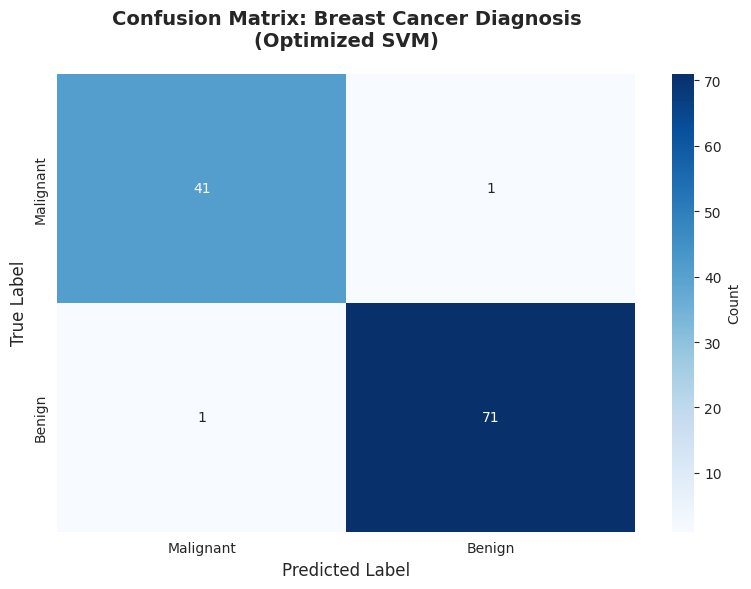


Error Analysis:
False Positives (Malignant predicted as Benign): 1
False Negatives (Benign predicted as Malignant): 1

Note: In medical diagnosis, minimizing false negatives is critical!


In [12]:
# 混同行列
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Breast Cancer Diagnosis\n(Optimized SVM)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# エラー分析
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
print(f"\nError Analysis:")
print(f"False Positives (Malignant predicted as Benign): {false_positives}")
print(f"False Negatives (Benign predicted as Malignant): {false_negatives}")
print(f"\nNote: In medical diagnosis, minimizing false negatives is critical!")

---

## 7. 他の分類器との比較

SVMの性能を、他の分類アルゴリズムと比較します。

In [13]:
# 複数のモデルを訓練
models = {
    'SVM (RBF)': SVC(kernel='rbf', C=10, gamma=0.001, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', C=1.0, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
}

results = []

print("Comparing multiple classifiers...\n")

for name, model in models.items():
    # 訓練
    model.fit(X_train_scaled, y_train)
    
    # 評価
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })
    
    print(f"{name}:")
    print(f"  Train: {train_acc:.4f} | Test: {test_acc:.4f} | CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 結果をDataFrameに変換
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(results_df.to_string(index=False))

Comparing multiple classifiers...



SVM (RBF):
  Train: 0.9802 | Test: 0.9825 | CV: 0.9736 (+/- 0.0164)
SVM (Linear):
  Train: 0.9912 | Test: 0.9737 | CV: 0.9670 (+/- 0.0139)
Logistic Regression:
  Train: 0.9890 | Test: 0.9825 | CV: 0.9802 (+/- 0.0128)
Decision Tree:
  Train: 1.0000 | Test: 0.9123 | CV: 0.9099 (+/- 0.0189)


Random Forest:
  Train: 1.0000 | Test: 0.9561 | CV: 0.9538 (+/- 0.0235)

MODEL COMPARISON SUMMARY
              Model  Train Accuracy  Test Accuracy  CV Mean   CV Std
          SVM (RBF)        0.980220       0.982456 0.973626 0.016447
Logistic Regression        0.989011       0.982456 0.980220 0.012815
       SVM (Linear)        0.991209       0.973684 0.967033 0.013900
      Random Forest        1.000000       0.956140 0.953846 0.023466
      Decision Tree        1.000000       0.912281 0.909890 0.018906


### 結果の可視化

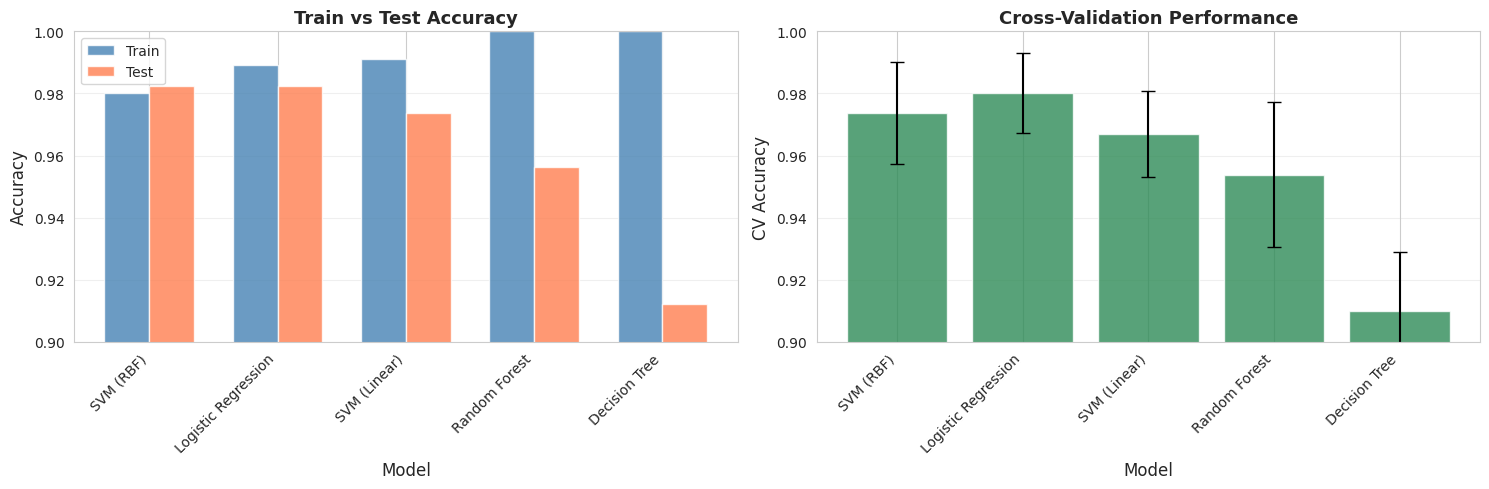

In [14]:
# バープロット
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train vs Test Accuracy
x = np.arange(len(results_df))
width = 0.35

axes[0].bar(x - width/2, results_df['Train Accuracy'], width, 
            label='Train', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, results_df['Test Accuracy'], width, 
            label='Test', alpha=0.8, color='coral')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Train vs Test Accuracy', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.9, 1.0])

# CV Mean with Error Bars
axes[1].bar(x, results_df['CV Mean'], yerr=results_df['CV Std'], 
            alpha=0.8, color='seagreen', capsize=5)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('CV Accuracy', fontsize=12)
axes[1].set_title('Cross-Validation Performance', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0.9, 1.0])

plt.tight_layout()
plt.show()

---

## まとめ

### 🎯 SVMの核心アイデア

```
1. マージン最大化
   - 決定境界と最も近いデータ点の距離を最大化
   - 汎化性能の向上につながる
   - サポートベクターだけがモデルを決定

2. カーネルトリック
   - 高次元空間での計算を効率的に行う
   - 非線形な境界を学習可能に
   - RBFカーネルが最も汎用的

3. 重要なハイパーパラメータ
   - C: 誤分類のペナルティ（正則化）
   - gamma: RBFカーネルの影響範囲
   - kernel: 使用するカーネル関数
```

---

### 📊 パラメータのチートシート

| パラメータ | 小さい値 | 大きい値 | デフォルト |
|-----------|---------|---------|-----------|
| **C** | マージン大、誤分類許容 | マージン小、誤分類厳しい | 1.0 |
| **gamma** | 滑らかな境界 | 複雑な境界 | 'scale' |

```
過学習している場合:
  → Cを下げる、gammaを下げる

未学習している場合:
  → Cを上げる、gammaを上げる
```

---

### 🚀 SVMを使う実践ガイド

```python
# 1. データの標準化（必須！）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. まず線形SVMを試す
from sklearn.svm import SVC
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X_train_scaled, y_train)

# 3. 非線形ならRBFカーネル
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf.fit(X_train_scaled, y_train)

# 4. GridSearchCVで最適化
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}
grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print(grid.best_params_)
```

---

### ✅ SVMの長所

| 長所 | 説明 |
|------|------|
| **高次元データに強い** | 特徴量数 > サンプル数でも有効 |
| **メモリ効率が良い** | サポートベクターのみ保存 |
| **非線形対応** | カーネルトリックで柔軟 |
| **過学習しにくい** | マージン最大化による正則化 |
| **少データでも有効** | 少数のサポートベクターで決定 |

### ❌ SVMの短所

| 短所 | 説明 |
|------|------|
| **大規模データに不向き** | O(n²〜n³)の計算量 |
| **確率出力が間接的** | `probability=True`で近似 |
| **前処理が必須** | 標準化しないと性能低下 |
| **解釈が難しい** | 特にカーネルSVM |
| **マルチクラスが間接的** | 1対1 or 1対他で対応 |

---

### 🎓 SVMを使うべき場面

```
SVMが適している:
  ✓ サンプル数が少〜中規模（〜10万）
  ✓ 特徴量数が多い（テキスト、遺伝子発現）
  ✓ 明確なマージンがありそうなデータ
  ✓ 高精度が必要だが解釈性は不要

他の手法を検討:
  ✗ 大規模データ（100万〜） → Random Forest, GBDT
  ✗ 解釈性が重要 → 決定木, ロジスティック回帰
  ✗ 画像・音声・テキスト → ディープラーニング
  ✗ リアルタイム予測が必要 → 線形モデル
```

---

### 📈 他のアルゴリズムとの比較

| アルゴリズム | 計算速度 | 精度 | 解釈性 | 大規模データ |
|-------------|---------|------|--------|-------------|
| **SVM (RBF)** | 遅い | 高い | 低い | ✗ |
| **SVM (Linear)** | 中程度 | 中程度 | 中程度 | △ |
| **ロジスティック回帰** | 速い | 中程度 | 高い | ○ |
| **Random Forest** | 中程度 | 高い | 中程度 | ○ |
| **GBDT** | 中程度 | 非常に高い | 低い | ○ |
| **k-NN** | 遅い | 中程度 | 中程度 | ✗ |

---

### 🔗 次のステップ

- **ノートブック07**: k-NN（k近傍法）とクラスタリング
- **発展**: SVR（サポートベクター回帰）で回帰問題に適用
- **実践**: Kaggleコンペでテキスト分類にSVMを適用

---

## 練習問題

1. **カーネル比較**: Irisデータセットで、異なるカーネルの性能を比較してください
2. **パラメータ可視化**: C vs gammaのヒートマップを作成し、最適領域を特定してください
3. **医療診断**: 他の医療データセット (糖尿病、心臓病など) でSVMを適用してください
4. **非線形データ生成**: make_moonsやmake_circlesのノイズパラメータを変えて、SVMの性能を評価してください
5. **アンサンブル**: 複数のSVMモデル (異なるカーネル) を組み合わせて、性能向上を試みてください

---

**Happy Learning! 🎯**